<a href="https://colab.research.google.com/github/YuJessica/113Dcapstone/blob/main/Capstone113.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial Setup

In [ ]:
### Import Overarching Libraries and Initialize Global Variables ###

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.layers import GlobalAveragePooling2D, ZeroPadding2D, Input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Upload and Prepare the Dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q opendatasets

import opendatasets as od

od.download('https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized') # insert kaggle username and key
# User: ranavarro2
# Key: 25048ecc59000cfce78650325beafc76

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ranavarro2
Your Kaggle Key: ··········


100%|██████████| 7.25G/7.25G [01:29<00:00, 86.6MB/s]


In [ ]:
# Initialize Global Variables

BS = 256
IMG_SIZE = 512
NUM_CLASSES = 5
seed = 653
learning_rate = 1e-3

# Use weights to counteract data imbalance during training
class_weights = {0:0.27219,
                 1:2.87564,
                 2:1.32751,
                 3:8.04719,
                 4:9.9226}
                 # Weight values are obtained by the equation:
                 # (num_IMGs_total)/(num_classes*num_IMGs_per_class)


Preprocess the
Dataset


In [ ]:
#Obtain dataset via directory

trainSet = tf.keras.preprocessing.image_dataset_from_directory(
           directory = "/content/diabetic-retinopathy-resized/processed",
           labels= 'inferred', # add inferred TO file name when processing img
           label_mode='int',
           color_mode='rgb',
           batch_size=BS,
           image_size=(IMG_SIZE, IMG_SIZE),
           shuffle=True,
           seed=seed,
           validation_split=0.2,
           subset="training",
)
validSet = tf.keras.preprocessing.image_dataset_from_directory(
           directory = "/content/diabetic-retinopathy-resized/processed",
           labels= 'inferred', # add inferred TO file name when processing img
           label_mode='int',
           color_mode='rgb',
           batch_size=BS,
           image_size=(IMG_SIZE, IMG_SIZE),
           shuffle=True,
           seed=seed,
           validation_split=0.2,
           subset="validation",
)
fullSet = tf.keras.preprocessing.image_dataset_from_directory(
           directory = "/content/diabetic-retinopathy-resized/processed",
           labels= 'inferred', # add inferred TO file name when processing img
           label_mode='int',
           color_mode='rgb',
           batch_size=BS,
           image_size=(IMG_SIZE, IMG_SIZE),
           shuffle=True,
           seed=seed,
)
def normalize(image,label):
    #Normalizes individual pixels of images
    image = tf.cast(image/255. ,tf.float32)
    return image,label

trainSet = trainSet.map(normalize) # apply normalization function to the entire image dataset
validSet = validSet.map(normalize)
fullSet = fullSet.map(normalize)

Found 35126 files belonging to 5 classes.
Using 28101 files for training.
Found 35126 files belonging to 5 classes.
Using 7025 files for validation.
Found 35126 files belonging to 5 classes.


Inspect Data

Build the Model

In [ ]:
# Import pretrained model (InceptionV3)

from tensorflow.keras.applications.inception_v3 import InceptionV3

modelBase = InceptionV3(input_shape = (IMG_SIZE, IMG_SIZE, 3), # shape of input images (height, width, channels)
                              include_top = False,             # top layer is specific to ImageNet competition; thus, should not be used for this model
                              weights = 'imagenet'
                              )
# disable training of layers in the model to prevent overfitting data
for layer in modelBase.layers:
  layer.trainable = False

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
from keras.layers import BatchNormalization, multiply, Lambda

base_model = modelBase
pt_depth = base_model.output_shape[-1]
inputLayer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
pt_features = base_model(inputLayer)
bn_features = BatchNormalization()(pt_features)


attentionLayer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attentionLayer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attentionLayer)
attentionLayer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attentionLayer)
attentionLayer = Conv2D(1,
                    kernel_size = (1,1),
                    padding = 'valid',
                    activation = 'sigmoid')(attentionLayer)
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same',
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attentionLayer = up_c2(attentionLayer)
mask_features = multiply([attentionLayer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attentionLayer)
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)


dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(NUM_CLASSES, activation = 'softmax')(dr_steps)
model = Model(inputs = inputLayer, outputs = [out_layer])

metrics = [
    #tf.keras.metrics.FalseNegatives(name="fn"),
    #tf.keras.metrics.FalsePositives(name="fp"),
    #tf.keras.metrics.TrueNegatives(name="tn"),
    #tf.keras.metrics.TruePositives(name="tp"),
    #tf.keras.metrics.Precision(name="precision"),
    #tf.keras.metrics.Recall(name="recall"),
]

#tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 inception_v3 (Functional)   (None, 14, 14, 2048)         2180278   ['input_2[0][0]']             
                                                          4                                       
                                                                                                  
 batch_normalization_94 (Ba  (None, 14, 14, 2048)         8192      ['inception_v3[0][0]']        
 tchNormalization)                                                                                
                                                                                              

Train the Model

In [ ]:
# Initialize Checkpoints

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    # At the end of each epoch, this checkpoint is called to save the model if it has the best outcome
    filepath="/content/drive/MyDrive/DRCNN/mymodelRetina.weights.h5",
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_weights_only = True
    )

reduceLROnPlat = ReduceLROnPlateau(
    # At the end of each epoch, this checkpoint is called to lower the learning rate if val_loss has plateaued
    monitor='loss',
    factor=0.8,
    patience=3,  # how much epochs of plateauing before adjusting learning rate
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-6)

early = EarlyStopping(
    # Ends training early if 'monitor' variable does not improve after 'patience' amount of epochs
    monitor="loss",
    mode="min",
    patience=10)


In [ ]:
# Train the network


#if os.path.exists("/content/drive/MyDrive/DRCNN/mymodelRetina.keras"):
 # model = tf.keras.models.load_model("/content/drive/MyDrive/DRCNN/mymodelRetina.keras", safe_mode=False)
print("training network...")
sys.stdout.flush()

H = model.fit(fullSet,
    callbacks=[model_checkpoint_callback, reduceLROnPlat, early],
    class_weight = class_weights,
    #validation_data = validSet,
    epochs=200, verbose=1,
    workers = 0, # tf-generators are not thread-safe
    use_multiprocessing=False,
    max_queue_size = 0
    )




training network...
Epoch 1/200
138/138 [==============================] - 78s 555ms/step - loss: 0.3080 - sparse_categorical_accuracy: 0.7348 - lr: 4.0960e-04
Epoch 2/200
138/138 [==============================] - 79s 565ms/step - loss: 0.2971 - sparse_categorical_accuracy: 0.7389 - lr: 4.0960e-04
Epoch 3/200
138/138 [==============================] - 77s 553ms/step - loss: 0.3014 - sparse_categorical_accuracy: 0.7398 - lr: 4.0960e-04
Epoch 4/200
138/138 [==============================] - 79s 566ms/step - loss: 0.2961 - sparse_categorical_accuracy: 0.7432 - lr: 4.0960e-04
Epoch 5/200
138/138 [==============================] - 77s 554ms/step - loss: 0.2967 - sparse_categorical_accuracy: 0.7388 - lr: 4.0960e-04
Epoch 6/200
138/138 [==============================] - 79s 566ms/step - loss: 0.2939 - sparse_categorical_accuracy: 0.7407 - lr: 4.0960e-04
Epoch 7/200
138/138 [==============================] - 79s 566ms/step - loss: 0.2934 - sparse_categorical_accuracy: 0.7459 - lr: 4.0960e-04


In [ ]:
model.evaluate(fullSet)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1920, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/confusion_metrics.py", line 77, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 672, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, 5) and (None, 1) are incompatible


In [ ]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')
model.load_weights("/content/drive/MyDrive/DRCNN/mymodel.weights.h5")
metrics = [
    #tf.keras.metrics.FalseNegatives(),
    #tf.keras.metrics.FalsePositives(),
    #tf.keras.metrics.TrueNegatives(),
    #tf.keras.metrics.TruePositives(),
    #tf.keras.metrics.Precision(),
    #tf.keras.metrics.Recall(),
    #tf.keras.metrics.AUC(name='auc', ),
    #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    tf.keras.metrics.Accuracy( )
]
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = 'f1_score')

model.evaluate(fullSet)

TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1920, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


In [ ]:
model.save_weights("/content/drive/MyDrive/DRCNN/mymodelRetina.weights.h5")

NameError: name 'model' is not defined

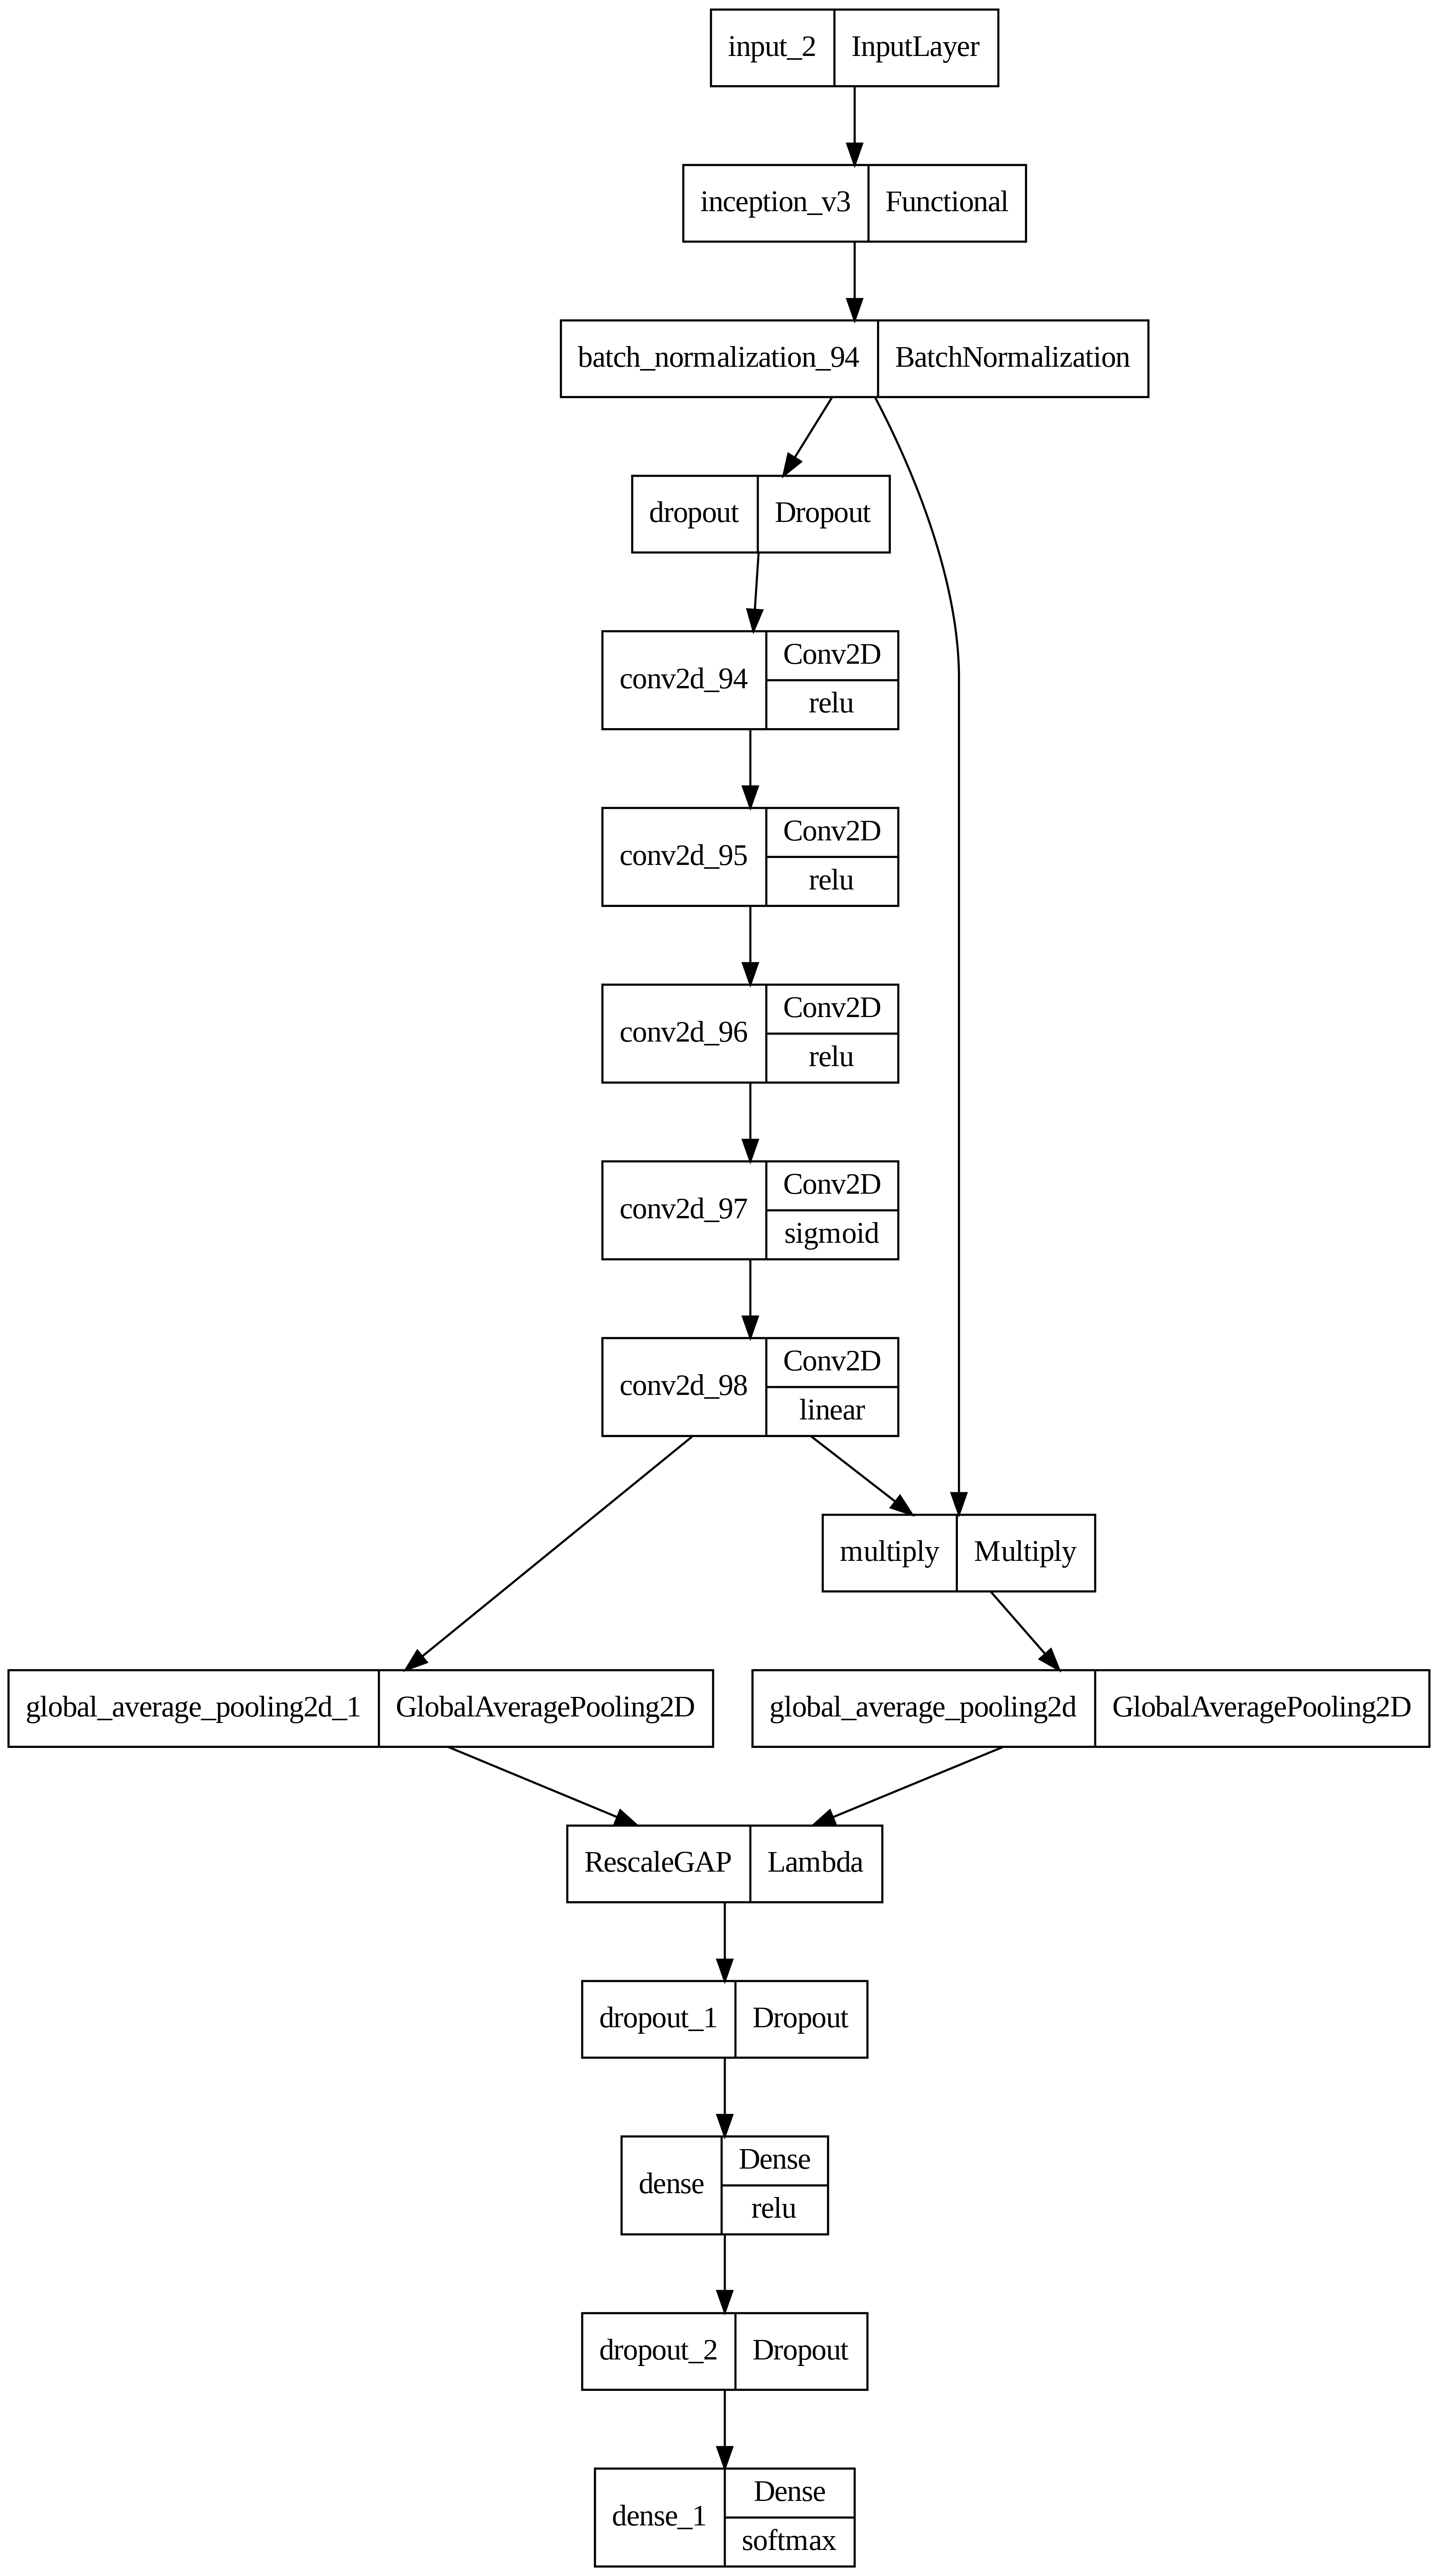

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    show_layer_activations=True,
    dpi=400,
)

In [ ]:
for attentionLayer in model.layers:
    c_shape = attentionLayer.output_shape
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attentionLayer)
            break

In [ ]:
import keras.backend as K
rand_idx = np.random.choice(range(len(fullSet)), size = 6)
attn_func = K.function(inputs = [model.input, K.learning_phase()],
           outputs = [attentionLayer.output]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*127+127, 0, 255).astype(np.uint8))
    attn_ax.imshow(attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max(), cmap = 'viridis',
                   vmin = 0, vmax = 1,
                   interpolation = 'lanczos')
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = retina_model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))
fig.savefig('attention_map.png', dpi = 300)

ValueError: Found unexpected instance while processing input tensors for keras functional model. Expecting KerasTensor which is from tf.keras.Input() or output from keras layer call(). Got: 0

In [ ]:
from keras.layers import BatchNormalization, multiply, Lambda

base_model = modelBase
pt_depth = base_model.output_shape[-1]
inputLayer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
pt_features = base_model(inputLayer)
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attentionLayer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attentionLayer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attentionLayer)
attentionLayer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attentionLayer)
attentionLayer = Conv2D(1,
                    kernel_size = (1,1),
                    padding = 'valid',
                    activation = 'sigmoid')(attentionLayer)

# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same',
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attentionLayer = up_c2(attentionLayer)
mask_features = multiply([attentionLayer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attentionLayer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(NUM_CLASSES, activation = 'softmax')(dr_steps)
model = Model(inputs = inputLayer, outputs = [out_layer])

#tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])
model.summary()
new_model =

SyntaxError: invalid syntax (<ipython-input-8-141a094977d9>, line 1)

In [ ]:
'''
Try:
X Larger Batches (low accuracy)
? Larger Batches + increased learning rate (inconsistent accuracy, should do more research)
X Larger images (takes too long)
O RGB images
? Lower dropout
- More dense layers
- Lower dropout & different weights (weights might have a larger effect when randomly dropping samples from the set)
O inception v3
'''

In [ ]:
''' OLD MODEL

def createModel():
    model =  Sequential()
    # first set of CONV => RELU => MAX POOL layers
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate = INIT_LR), metrics=["sparse_categorical_accuracy"])
    return model

model = createModel()

model.summary()


In [ ]:
''' OLD SIMPLE MODEL (too litle layers, doesn't learn well)
model = Sequential()
model.add(modelBase)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), # if model converges too quickly on high loss, lower the learning rate
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              )

model.summary()
'''

In [ ]:
class_names = trainSet.class_names
for images, labels in trainSet.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: '_MapDataset' object has no attribute 'class_names'